In [12]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install required packages if not available
try:
    import seaborn as sns
    print("[OK] seaborn imported successfully")
except ImportError:
    print("[INSTALL] Installing seaborn...")
    !pip install seaborn
    import seaborn as sns

try:
    import tensorflow as tf
    print(f"[OK] TensorFlow {tf.__version__} imported successfully")
except ImportError:
    print("[INSTALL] Installing tensorflow...")
    !pip install tensorflow
    import tensorflow as tf

from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Bidirectional, Conv1D, 
    Dropout, Flatten, AveragePooling1D, MaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Attention mechanism - using TensorFlow built-in layers
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
print("[OK] Using TensorFlow built-in attention mechanism")

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    mean_absolute_percentage_error, r2_score
)
from sklearn.model_selection import train_test_split

print(f"[OK] All libraries imported successfully!")
print(f"[OK] TensorFlow version: {tf.__version__}")
print(f"[OK] Using GPU: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline
sns.set_style('whitegrid')

[OK] seaborn imported successfully
[OK] TensorFlow 2.18.0 imported successfully
[OK] Using TensorFlow built-in attention mechanism
[OK] All libraries imported successfully!
[OK] TensorFlow version: 2.18.0
[OK] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 1. Load Preprocessed Data

Tải dữ liệu đã được xử lý từ notebook `01_data_preprocessing.ipynb`

In [13]:
# Detect environment and set paths
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
IN_COLAB = 'google.colab' in sys.modules

if IN_KAGGLE:
    # Kaggle: Use input data from uploaded dataset
    data_dir = Path("/kaggle/input/processed")
    print(f"[KAGGLE] Loading from: {data_dir}")
elif IN_COLAB:
    # Colab: Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path("/content/drive/MyDrive/pm25-data/processed")
    print(f"[COLAB] Loading from Google Drive: {data_dir}")
else:
    # Local development
    data_dir = Path("../data/processed")
    print(f"[LOCAL] Loading from: {data_dir}")

# Check if data exists
if not data_dir.exists():
    print(f"[ERROR] Data directory not found: {data_dir}")
    print(f"[INFO] Please run 01_data_preprocessing.ipynb first to generate preprocessed data")
    sys.exit(1)
else:
    print(f"[SUCCESS] Data directory found: {data_dir}")

[KAGGLE] Loading from: /kaggle/input/processed
[SUCCESS] Data directory found: /kaggle/input/processed


In [14]:
# Load LSTM sequence data (24 timesteps) for fair comparison
print("[LOADING] Loading CNN1D-BiLSTM sequence data (24 timesteps)...")

try:
    # Load preprocessed sequence data
    cnn_train = pd.read_parquet(data_dir / 'lstm_sequences' / 'train')
    cnn_val = pd.read_parquet(data_dir / 'lstm_sequences' / 'val')
    cnn_test = pd.read_parquet(data_dir / 'lstm_sequences' / 'test')
    
    print(f"[SUCCESS] Data loaded successfully:")
    print(f"   Train: {cnn_train.shape}")
    print(f"   Val:   {cnn_val.shape}")
    print(f"   Test:  {cnn_test.shape}")
    
    # Load metadata
    with open(data_dir / 'feature_metadata.json', 'r') as f:
        feature_metadata = json.load(f)
    
    with open(data_dir / 'scaler_params.json', 'r') as f:
        scaler_params = json.load(f)
        
    print(f"[SUCCESS] Metadata loaded:")
    print(f"   Features: {len(feature_metadata['deep_learning_features'])}")
    print(f"   Target: {feature_metadata['target']}")
    
except FileNotFoundError as e:
    print(f"[ERROR] Required files not found: {e}")
    print(f"[INFO] Make sure to run the preprocessing notebook first")
    sys.exit(1)

[LOADING] Loading CNN1D-BiLSTM sequence data (24 timesteps)...
[SUCCESS] Data loaded successfully:
   Train: (201482, 21)
   Val:   (42725, 21)
   Test:  (42934, 21)
[SUCCESS] Metadata loaded:
   Features: 18
   Target: PM2_5_log_scaled


In [15]:
# Inspect the data structure
print("[INSPECT] Data structure analysis:")
print("-" * 50)

print("\n[COLUMNS] Available columns:")
for i, col in enumerate(cnn_train.columns):
    print(f"   {i+1:2d}. {col}")

print(f"\n[SEQUENCES] Sequence features:")
sequence_cols = [col for col in cnn_train.columns if col.endswith('_sequence')]
print(f"   Total: {len(sequence_cols)} sequence features")

# Show first few sequence feature names
for col in sequence_cols[:5]:
    print(f"   - {col}")
if len(sequence_cols) > 5:
    print(f"   ... and {len(sequence_cols) - 5} more")

print(f"\n[TARGET] Target variable: target_value")
print(f"   Values range: [{cnn_train['target_value'].min():.4f}, {cnn_train['target_value'].max():.4f}]")

print(f"\n[METADATA] Sequence characteristics:")
# Check sequence length by examining one sequence
sample_sequence = cnn_train[sequence_cols[0]].iloc[0]
sequence_length = len(sample_sequence)
n_features = len(sequence_cols)

print(f"   Sequence length: {sequence_length} timesteps")
print(f"   Number of features: {n_features}")
print(f"   Input shape will be: (batch_size, {sequence_length}, {n_features})")
print(f"   Note: Using 24 timesteps for fair comparison with LSTM and XGBoost models")

[INSPECT] Data structure analysis:
--------------------------------------------------

[COLUMNS] Available columns:
    1. location_id
    2. datetime
    3. PM10_scaled_sequence
    4. NO2_scaled_sequence
    5. SO2_scaled_sequence
    6. temperature_2m_scaled_sequence
    7. relative_humidity_2m_scaled_sequence
    8. wind_speed_10m_scaled_sequence
    9. surface_pressure_scaled_sequence
   10. precipitation_scaled_sequence
   11. hour_sin_sequence
   12. hour_cos_sequence
   13. month_sin_sequence
   14. month_cos_sequence
   15. day_of_week_sin_sequence
   16. day_of_week_cos_sequence
   17. wind_direction_sin_sequence
   18. wind_direction_cos_sequence
   19. is_weekend_sequence
   20. PM2_5_log_scaled_sequence
   21. target_value

[SEQUENCES] Sequence features:
   Total: 18 sequence features
   - PM10_scaled_sequence
   - NO2_scaled_sequence
   - SO2_scaled_sequence
   - temperature_2m_scaled_sequence
   - relative_humidity_2m_scaled_sequence
   ... and 13 more

[TARGET] Target v

## 2. Prepare Data for Deep Learning

Chuyển đổi dữ liệu Pandas thành numpy arrays phù hợp cho Keras/TensorFlow

In [16]:
def prepare_sequence_data(df, sequence_cols, target_col='target_value'):
    """
    Convert pandas DataFrame with sequence columns to numpy arrays
    
    Args:
        df: DataFrame with sequence columns (arrays in each cell)
        sequence_cols: List of sequence column names
        target_col: Target column name
    
    Returns:
        X: numpy array of shape (samples, timesteps, features)
        y: numpy array of shape (samples,)
    """
    print(f"   Converting {len(df)} samples...")
    
    # Extract sequences
    X = np.array([
        np.stack([df[col].iloc[i] for col in sequence_cols], axis=0)
        for i in range(len(df))
    ])
    
    # Transpose to (samples, timesteps, features) for Keras
    X = X.transpose(0, 2, 1)
    
    # Extract target values
    y = df[target_col].values
    
    print(f"   X shape: {X.shape} (samples, timesteps, features)")
    print(f"   y shape: {y.shape}")
    
    return X, y

print("[PROCESSING] Converting sequence data to numpy arrays...")

# Convert training data
print("\n[TRAIN] Training data:")
X_train, y_train = prepare_sequence_data(cnn_train, sequence_cols)

# Convert validation data
print("\n[VAL] Validation data:")
X_val, y_val = prepare_sequence_data(cnn_val, sequence_cols)

# Convert test data
print("\n[TEST] Test data:")
X_test, y_test = prepare_sequence_data(cnn_test, sequence_cols)

print(f"\n[SUCCESS] Data preparation completed!")
print(f"   Total training samples: {len(X_train):,}")
print(f"   Total validation samples: {len(X_val):,}")
print(f"   Total test samples: {len(X_test):,}")
print(f"   Input shape: {X_train.shape}")
print(f"   Target range: [{y_train.min():.4f}, {y_train.max():.4f}]")

[PROCESSING] Converting sequence data to numpy arrays...

[TRAIN] Training data:
   Converting 201482 samples...
   X shape: (201482, 24, 18) (samples, timesteps, features)
   y shape: (201482,)

[VAL] Validation data:
   Converting 42725 samples...
   X shape: (42725, 24, 18) (samples, timesteps, features)
   y shape: (42725,)

[TEST] Test data:
   Converting 42934 samples...
   X shape: (42934, 24, 18) (samples, timesteps, features)
   y shape: (42934,)

[SUCCESS] Data preparation completed!
   Total training samples: 201,482
   Total validation samples: 42,725
   Total test samples: 42,934
   Input shape: (201482, 24, 18)
   Target range: [0.0000, 1.0000]


In [17]:
# Data quality checks
print("[QUALITY] Data quality verification:")
print("-" * 50)

# Check for NaN values
print(f"\n[NAN] NaN values check:")
print(f"   X_train NaN: {np.isnan(X_train).sum()}")
print(f"   y_train NaN: {np.isnan(y_train).sum()}")
print(f"   X_val NaN: {np.isnan(X_val).sum()}")
print(f"   y_val NaN: {np.isnan(y_val).sum()}")

# Check data ranges
print(f"\n[RANGES] Data ranges:")
print(f"   X_train: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"   X_val: [{X_val.min():.4f}, {X_val.max():.4f}]")
print(f"   y_train: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"   y_val: [{y_val.min():.4f}, {y_val.max():.4f}]")

# Check for infinite values
print(f"\n[INF] Infinite values check:")
print(f"   X_train inf: {np.isinf(X_train).sum()}")
print(f"   y_train inf: {np.isinf(y_train).sum()}")

if (np.isnan(X_train).sum() == 0 and np.isnan(y_train).sum() == 0 and 
    np.isinf(X_train).sum() == 0 and np.isinf(y_train).sum() == 0):
    print(f"\n[SUCCESS] Data quality check passed - no NaN or infinite values!")
else:
    print(f"\n[ERROR] Data quality issues detected!")

[QUALITY] Data quality verification:
--------------------------------------------------

[NAN] NaN values check:
   X_train NaN: 0
   y_train NaN: 0
   X_val NaN: 0
   y_val NaN: 0

[RANGES] Data ranges:
   X_train: [-1.0000, 1.0000]
   X_val: [-1.0000, 1.0522]
   y_train: [0.0000, 1.0000]
   y_val: [0.0000, 0.9268]

[INF] Infinite values check:
   X_train inf: 0
   y_train inf: 0

[SUCCESS] Data quality check passed - no NaN or infinite values!


In [18]:
# Enhanced metrics calculation function - Safe version to avoid division by zero
def calculate_metrics_safe(y_true, y_pred, model_name="Model"):
    """Calculate and display regression metrics for PM2.5 prediction - Safe version"""
    
    # Calculate core metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Safe calculation of percentage-based metrics
    # Only use non-zero values to avoid division by zero
    non_zero_mask = np.abs(y_true) > 1e-3  # Values > 0.001
    
    if np.sum(non_zero_mask) > 10:  # Need at least 10 non-zero values
        # Calculate MAPE safely
        try:
            mape = mean_absolute_percentage_error(y_true[non_zero_mask], y_pred[non_zero_mask]) * 100
            mape = min(mape, 500.0)  # Cap at 500%
        except:
            mape = float('inf')
        
        # Calculate MRE safely
        try:
            relative_errors = (y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask] * 100
            mre = np.median(relative_errors)  # Use median instead of mean for robustness
            mre = np.clip(mre, -500, 500)  # Cap at ±500%
        except:
            mre = 0.0
    else:
        mape = float('inf')
        mre = 0.0
    
    # Print results with improved formatting
    print(f"\n[METRICS] {model_name} Performance:")
    print("-" * 60)
    print(f"   R²:   {r2:.6f}   (Coefficient of Determination)")
    print(f"   RMSE: {rmse:.6f}   (Root Mean Square Error)")  
    print(f"   MAE:  {mae:.6f}   (Mean Absolute Error)")
    
    if mape == float('inf'):
        print(f"   MAPE: N/A        (Cannot calculate - too many zero values)")
    else:
        print(f"   MAPE: {mape:.4f}%   (Mean Absolute Percentage Error)")
    
    print(f"   MRE:  {mre:.4f}%   (Mean Relative Error - median)")
    print("-" * 60)
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape if mape != float('inf') else None,
        'mre': mre,
        'mse': mse
    }

# Denormalization function for PM2.5 values (Updated for Log Transformation)
def denormalize_pm25(normalized_values, scaler_params):
    """
    Denormalize PM2.5 values to original scale
    
    IMPORTANT: If log transformation was applied during preprocessing:
    1. First denormalize: scaled -> log(1 + PM2.5)
    2. Then inverse log: expm1 -> PM2.5
    
    Auto-detect: Check if 'PM2_5_log' exists in scaler_params
    """
    # Auto-detect if log transformation was applied
    # If 'PM2_5_log' exists, it means log transform was used
    if 'PM2_5_log' in scaler_params:
        # Log transformation was applied
        pm25_params = scaler_params['PM2_5_log']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Step 1: Denormalize to log scale
        log_values = normalized_values * (max_val - min_val) + min_val
        
        # Step 2: Inverse log transform: exp(x) - 1
        original_values = np.expm1(log_values)
        
        print(f"[DENORM] Applied inverse log transform (expm1) after denormalization")
        print(f"   Log scale range: [{log_values.min():.4f}, {log_values.max():.4f}]")
        print(f"   Original scale range: [{original_values.min():.2f}, {original_values.max():.2f}] μg/m³")
    
    elif 'PM2_5' in scaler_params:
        # Standard normalization (no log transform)
        pm25_params = scaler_params['PM2_5']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Reverse Min-Max normalization: original = normalized * (max - min) + min
        original_values = normalized_values * (max_val - min_val) + min_val
        
        print(f"[DENORM] Standard denormalization (no log transform)")
        print(f"   Original scale range: [{original_values.min():.2f}, {original_values.max():.2f}] μg/m³")
    
    else:
        raise KeyError(f"Neither 'PM2_5' nor 'PM2_5_log' found in scaler_params. Available keys: {list(scaler_params.keys())}")
    
    return original_values

def denormalize_pm25_simple(normalized_values, scaler_params):
    """
    Simple denormalization without inverse log (for comparison in normalized space)
    """
    pm25_params = scaler_params.get('PM2_5_log', scaler_params.get('PM2_5'))
    min_val = pm25_params['min']
    max_val = pm25_params['max']
    
    original_values = normalized_values * (max_val - min_val) + min_val
    return original_values

print("[FUNCTIONS] Metrics and utility functions defined!")
print("[INFO] denormalize_pm25() now supports log transformed targets")

[FUNCTIONS] Metrics and utility functions defined!
[INFO] denormalize_pm25() now supports log transformed targets


In [19]:
# Advanced data analysis to understand model limitations
def analyze_data_distribution(y_train, y_val, y_test):
    """Analyze the distribution of target values to understand potential issues"""
    
    print("[ANALYSIS] Data Distribution Analysis:")
    print("=" * 60)
    
    # Combine all data for analysis
    all_data = np.concatenate([y_train, y_val, y_test])
    
    # Calculate percentiles
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    values = np.percentile(all_data, percentiles)
    
    print(f"\n[PERCENTILES] Target value distribution:")
    for p, v in zip(percentiles, values):
        print(f"   {p:2d}th percentile: {v:.4f}")
    
    # Check for extreme values
    q1, q3 = np.percentile(all_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (all_data < lower_bound) | (all_data > upper_bound)
    outlier_count = np.sum(outliers)
    
    print(f"\n[OUTLIERS] Outlier analysis:")
    print(f"   IQR: {iqr:.4f}")
    print(f"   Lower bound: {lower_bound:.4f}")
    print(f"   Upper bound: {upper_bound:.4f}")
    print(f"   Outliers: {outlier_count:,} ({outlier_count/len(all_data)*100:.2f}%)")
    
    # Check data balance
    zero_near_count = np.sum(all_data < 0.01)
    high_value_count = np.sum(all_data > 0.8)
    
    print(f"\n[BALANCE] Data balance check:")
    print(f"   Near-zero values (< 0.01): {zero_near_count:,} ({zero_near_count/len(all_data)*100:.2f}%)")
    print(f"   High values (> 0.8): {high_value_count:,} ({high_value_count/len(all_data)*100:.2f}%)")
    
    # Recommendations
    print(f"\n[RECOMMENDATIONS] Based on data analysis:")
    
    if outlier_count > len(all_data) * 0.05:
        print(f" High outlier ratio ({outlier_count/len(all_data)*100:.1f}%) - consider robust scaling")
    
    if zero_near_count > len(all_data) * 0.1:
        print(f" Many near-zero values - may cause MAPE issues")
    
    if high_value_count < len(all_data) * 0.01:
        print(f" Few high values - model may struggle with extreme predictions")
        
    return {
        'percentiles': dict(zip(percentiles, values)),
        'outlier_ratio': outlier_count/len(all_data),
        'zero_ratio': zero_near_count/len(all_data),
        'high_ratio': high_value_count/len(all_data)
    }

# Run the analysis
data_stats = analyze_data_distribution(y_train, y_val, y_test)

# Enhanced data preprocessing suggestions
print(f"\n[SUGGESTIONS] Model improvement suggestions:")
print(f"   1. Use robust scaling (quantile-based) instead of min-max")
print(f"   2. Implement weighted loss function for extreme values")
print(f"   3. Consider ensemble methods (multiple models)")
print(f"   4. Add temporal features (hour, day, season)")
print(f"   5. Location-specific normalization")
print("=" * 60)

[ANALYSIS] Data Distribution Analysis:

[PERCENTILES] Target value distribution:
    1th percentile: 0.1540
    5th percentile: 0.2804
   10th percentile: 0.3400
   25th percentile: 0.4293
   50th percentile: 0.5197
   75th percentile: 0.6021
   90th percentile: 0.6690
   95th percentile: 0.7081
   99th percentile: 0.7749

[OUTLIERS] Outlier analysis:
   IQR: 0.1728
   Lower bound: 0.1700
   Upper bound: 0.8614
   Outliers: 3,678 (1.28%)

[BALANCE] Data balance check:
   Near-zero values (< 0.01): 75 (0.03%)
   High values (> 0.8): 1,575 (0.55%)

[RECOMMENDATIONS] Based on data analysis:
 Few high values - model may struggle with extreme predictions

[SUGGESTIONS] Model improvement suggestions:
   1. Use robust scaling (quantile-based) instead of min-max
   2. Implement weighted loss function for extreme values
   3. Consider ensemble methods (multiple models)
   4. Add temporal features (hour, day, season)
   5. Location-specific normalization


In [20]:
# Create weighted loss function for better extreme value handling
def create_weighted_mse_loss(y_true_sample):
    """
    Create a weighted MSE loss that puts more emphasis on extreme values
    """
    def weighted_mse(y_true, y_pred):
        # Calculate weights based on target magnitude
        # Higher weights for extreme values (both high and low)
        weights = tf.where(
            y_true < 0.1,  # Low values
            2.0,  # Double weight for low values
            tf.where(
                y_true > 0.7,  # High values  
                3.0,  # Triple weight for high values
                1.0   # Normal weight for medium values
            )
        )
        
        # Calculate weighted MSE
        squared_diff = tf.square(y_true - y_pred)
        weighted_loss = weights * squared_diff
        return tf.reduce_mean(weighted_loss)
    
    return weighted_mse

# Alternative: Huber loss for robustness to outliers
def huber_loss_custom(delta=0.1):
    """
    Custom Huber loss - more robust to outliers than MSE
    """
    def huber(y_true, y_pred):
        error = y_true - y_pred
        condition = tf.abs(error) <= delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = delta * tf.abs(error) - 0.5 * tf.square(delta)
        return tf.where(condition, squared_loss, linear_loss)
    
    return huber

print("[LOSS] Advanced loss functions defined:")
print("   • Weighted MSE: Emphasizes extreme values (low/high PM2.5)")  
print("   • Huber Loss: Robust to outliers")
print("   • Ready to use in model compilation")

[LOSS] Advanced loss functions defined:
   • Weighted MSE: Emphasizes extreme values (low/high PM2.5)
   • Huber Loss: Robust to outliers
   • Ready to use in model compilation


In [21]:
# ========================================
# CUSTOM LOSS FUNCTIONS
# ========================================

def weighted_mse_loss(y_true, y_pred):
    """
    Weighted MSE: Ưu tiên dự đoán giá trị cao (extreme pollution)
    
    Logic:
    - PM2.5_log_scaled > 3.5 (≈ 32 μg/m³): weight = 2.5
    - PM2.5_log_scaled > 3.0 (≈ 19 μg/m³): weight = 1.8
    - PM2.5_log_scaled > 2.5 (≈ 11 μg/m³): weight = 1.3
    - Others: weight = 1.0
    """
    squared_error = tf.square(y_true - y_pred)
    
    # Dynamic weights based on pollution level
    weights = tf.where(
        y_true > 3.5,
        2.5,  # Severe pollution
        tf.where(
            y_true > 3.0,
            1.8,  # High pollution
            tf.where(
                y_true > 2.5,
                1.3,  # Moderate pollution
                1.0   # Normal pollution
            )
        )
    )
    
    weighted_loss = weights * squared_error
    return tf.reduce_mean(weighted_loss)


def focal_mse_loss(y_true, y_pred, gamma=1.5):
    """
    Focal Loss for Regression: Focus on hard-to-predict examples
    
    Formula: Loss = |error|^gamma * MSE
    - Small errors: Low weight
    - Large errors: High weight (focus more)
    """
    mse = tf.square(y_true - y_pred)
    abs_error = tf.abs(y_true - y_pred)
    focal_weight = tf.pow(abs_error + 1e-7, gamma)  # Avoid zero
    focal_loss = focal_weight * mse
    return tf.reduce_mean(focal_loss)


def combined_loss(y_true, y_pred, alpha=0.6, beta=0.4, gamma=1.5):
    """
    Combined Loss: Weighted MSE + Focal MSE
    
    Args:
        alpha: Weight for weighted_mse
        beta: Weight for focal_mse
        gamma: Focal loss gamma parameter
    """
    weighted_loss = weighted_mse_loss(y_true, y_pred)
    focal_loss = focal_mse_loss(y_true, y_pred, gamma)
    return alpha * weighted_loss + beta * focal_loss

## 3. Build CNN1D + BiLSTM + Attention Model

Tạo mô hình theo kiến trúc đề xuất trong đề tài

In [26]:
# ========================================
# CUSTOM LAYERS
# ========================================

class AttentionWeightedPooling(tf.keras.layers.Layer):
    """
    Custom layer for attention-weighted pooling
    
    This layer learns to assign importance weights to each timestep
    and computes a weighted sum, allowing the model to focus on
    important temporal moments.
    
    Advantages over Lambda:
    - Serializable (can save/load easily)
    - Has proper get_config() method
    - Professional and maintainable
    """
    
    def __init__(self, **kwargs):
        super(AttentionWeightedPooling, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """Build layer - create attention weight matrix"""
        # input_shape: (batch, timesteps, features)
        self.attention_dense = Dense(
            1, 
            activation='softmax',
            name='attention_weights_dense'
        )
        super(AttentionWeightedPooling, self).build(input_shape)
    
    def call(self, inputs):
        """Forward pass"""
        # Step 1: Compute attention weights
        # Shape: (batch, timesteps, features) -> (batch, timesteps, 1)
        attention_weights = self.attention_dense(inputs)
        
        # Step 2: Apply attention weights (element-wise multiplication)
        # Shape: (batch, timesteps, features) * (batch, timesteps, 1)
        #     -> (batch, timesteps, features)
        weighted_input = inputs * attention_weights
        
        # Step 3: Sum over timesteps
        # Shape: (batch, timesteps, features) -> (batch, features)
        output = tf.reduce_sum(weighted_input, axis=1)
        
        return output
    
    def get_config(self):
        """Enable serialization"""
        config = super(AttentionWeightedPooling, self).get_config()
        return config
    
    def compute_output_shape(self, input_shape):
        """Define output shape"""
        # Input: (batch, timesteps, features)
        # Output: (batch, features)
        return (input_shape[0], input_shape[2])

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, LSTM, Bidirectional, 
                                     MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, GlobalAveragePooling1D,
                                     BatchNormalization, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import math
import time

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, LSTM, Bidirectional, 
                                     MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, BatchNormalization, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import math
import time
import json

# ========================================
# OPTIMIZED MODEL v3.2 - NO POOLING
# ========================================

def create_cnn_bilstm_attention_model(input_shape, 
                                    cnn_filters=[32, 64],
                                    cnn_kernel_size=3,
                                    lstm_units=64,
                                    dropout_rate=0.25,
                                    dense_units=64,
                                    learning_rate=0.001,
                                    l2_reg=0.015):
    """
    OPTIMIZED CNN1D + BiLSTM + Attention for 24 timesteps
    
    KEY IMPROVEMENTS v3.2:
    - NO pooling layer (keep all 24 timesteps)
    - Simplified CNN (2 layers)
    - Single BiLSTM layer
    - 2 attention heads (reduced)
    - Higher regularization
    - Gradient clipping
    
    Args:
        input_shape: (timesteps, features) - expect (24, 17)
        cnn_filters: List of CNN filter sizes
        cnn_kernel_size: CNN kernel size
        lstm_units: BiLSTM units
        dropout_rate: Dropout rate
        dense_units: Dense layer units
        learning_rate: Learning rate for optimizer
        l2_reg: L2 regularization factor
    
    Returns:
        Compiled Keras model
    """
    
    print(f"[MODEL] Building OPTIMIZED CNN1D + BiLSTM + Attention v3.2:")
    print(f"   Input shape: {input_shape}")
    print(f"   CNN filters: {cnn_filters}")
    print(f"   Kernel size: {cnn_kernel_size}")
    print(f"   LSTM units: {lstm_units}")
    print(f"   Dropout rate: {dropout_rate}")
    print(f"   L2 regularization: {l2_reg}")
    
    # Input layer
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # Simplified CNN1D layers (2 layers only)
    x = input_layer
    for i, filters in enumerate(cnn_filters):
        x = Conv1D(
            filters=filters, 
            kernel_size=cnn_kernel_size, 
            padding='same', 
            activation='relu',
            kernel_regularizer=l2(l2_reg),
            name=f'cnn1d_{i+1}'
        )(x)
        x = BatchNormalization(name=f'bn_cnn_{i+1}')(x)
        x = Dropout(dropout_rate * 0.5, name=f'cnn_dropout_{i+1}')(x)  # Light dropout after CNN
    
    # ✅ NO POOLING - Keep all 24 timesteps for maximum temporal information
    
    # Single Bidirectional LSTM layer
    x = Bidirectional(
        LSTM(units=lstm_units, 
             return_sequences=True, 
             kernel_regularizer=l2(l2_reg), 
             recurrent_regularizer=l2(l2_reg),
             dropout=dropout_rate,
             recurrent_dropout=0.0,  # No recurrent dropout (causes instability)
             name='bilstm'),
        name='bidirectional'
    )(x)
    
    # Simplified Multi-Head Attention (2 heads)
    attention_output = MultiHeadAttention(
        num_heads=2,            # Reduced from 4 to 2
        key_dim=32,             # Key dimension
        dropout=dropout_rate,
        name='multi_head_attention'
    )(x, x)  # Self-attention
    
    # Add & Norm with residual connection
    x = LayerNormalization(name='attention_norm')(x + attention_output)
    x = Dropout(dropout_rate, name='attention_dropout')(x)
    
    # Global average pooling to reduce sequence dimension
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    
    # Simplified Dense layers (2 layers)
    x = Dense(units=dense_units, 
              activation='relu', 
              kernel_regularizer=l2(l2_reg), 
              name='dense_1')(x)
    x = BatchNormalization(name='bn_dense_1')(x)
    x = Dropout(dropout_rate, name='dropout_1')(x)
    
    x = Dense(units=dense_units//2, 
              activation='relu', 
              kernel_regularizer=l2(l2_reg), 
              name='dense_2')(x)
    x = Dropout(dropout_rate, name='dropout_2')(x)
    
    # Output layer for regression
    output = Dense(units=1, 
                   activation='linear', 
                   kernel_regularizer=l2(l2_reg), 
                   name='output')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output, name='CNN_BiLSTM_Attention_v3_2')
    
    # Compile with gradient clipping
    optimizer = Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0  # Gradient clipping for stability
    )
    
    # Use Huber loss - robust to outliers
    model.compile(
        optimizer=optimizer,
        loss='huber',  # More robust than MSE for log-transformed targets
        metrics=['mae', 'mse']
    )
    
    return model

def create_ultimate_model(input_shape, 
                         cnn_filters=[32, 64],
                         cnn_kernel_size=3,
                         lstm_units=64,
                         dropout_rate=0.25,
                         dense_units=64,
                         learning_rate=0.001,
                         l2_reg=0.015,
                         use_residual=True,
                         use_attention_pooling=True,
                         loss_type='combined'):
    """
    ULTIMATE CNN-BiLSTM Model v5.0
    
    NEW FEATURES:
    ✅ Residual connections for better gradient flow
    ✅ Attention-weighted pooling (replaces GlobalAvgPool)
    ✅ Custom loss functions (weighted/focal/combined)
    ✅ Improved architecture for extreme value prediction
    
    Args:
        input_shape: (timesteps, features)
        use_residual: Enable residual connections
        use_attention_pooling: Use attention weights for pooling
        loss_type: 'mse', 'huber', 'weighted', 'focal', 'combined'
    """
    
    print(f"\n{'='*70}")
    print(f"🚀 BUILDING ULTIMATE MODEL v5.0")
    print(f"{'='*70}")
    print(f"📐 Architecture:")
    print(f"   • Input shape: {input_shape}")
    print(f"   • CNN filters: {cnn_filters}")
    print(f"   • LSTM units: {lstm_units}")
    print(f"   • Residual connections: {use_residual}")
    print(f"   • Attention pooling: {use_attention_pooling}")
    print(f"   • Loss function: {loss_type}")
    print(f"   • L2 regularization: {l2_reg}")
    print(f"   • Dropout rate: {dropout_rate}")
    print(f"{'='*70}\n")
    
    # Input layer
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # Initial projection to match filter size (for residual)
    x = Conv1D(
        filters=cnn_filters[0],
        kernel_size=1,
        padding='same',
        name='initial_projection'
    )(input_layer)
    
    # ========================================
    # CNN BLOCKS with Residual Connections
    # ========================================
    
    for i, filters in enumerate(cnn_filters):
        # Store residual
        if use_residual:
            residual = x
            # Project residual if dimensions don't match
            if residual.shape[-1] != filters:
                residual = Conv1D(
                    filters=filters,
                    kernel_size=1,
                    padding='same',
                    name=f'residual_projection_{i+1}'
                )(residual)
        
        # CNN layer 1
        x = Conv1D(
            filters=filters,
            kernel_size=cnn_kernel_size,
            padding='same',
            activation='relu',
            kernel_regularizer=l2(l2_reg),
            name=f'cnn1d_{i+1}_a'
        )(x)
        x = BatchNormalization(name=f'bn_cnn_{i+1}_a')(x)
        x = Dropout(dropout_rate * 0.3, name=f'dropout_cnn_{i+1}_a')(x)
        
        # CNN layer 2 (deeper block)
        x = Conv1D(
            filters=filters,
            kernel_size=cnn_kernel_size,
            padding='same',
            activation='relu',
            kernel_regularizer=l2(l2_reg),
            name=f'cnn1d_{i+1}_b'
        )(x)
        x = BatchNormalization(name=f'bn_cnn_{i+1}_b')(x)
        
        # Add residual connection
        if use_residual:
            x = Add(name=f'residual_add_{i+1}')([x, residual])
        
        x = Dropout(dropout_rate * 0.5, name=f'dropout_cnn_{i+1}_b')(x)
    
    # ========================================
    # BiLSTM with Residual
    # ========================================
    
    if use_residual:
        residual_lstm = x
        # Project to match BiLSTM output dimension (2 * lstm_units)
        residual_lstm = Conv1D(
            filters=lstm_units * 2,
            kernel_size=1,
            padding='same',
            name='residual_projection_lstm'
        )(residual_lstm)
    
    x = Bidirectional(
        LSTM(
            units=lstm_units,
            return_sequences=True,
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg),
            dropout=dropout_rate,
            recurrent_dropout=0.0,
            name='bilstm'
        ),
        name='bidirectional'
    )(x)
    
    # Add residual connection
    if use_residual:
        x = Add(name='residual_add_lstm')([x, residual_lstm])
    
    # ========================================
    # Multi-Head Attention
    # ========================================
    
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        dropout=dropout_rate,
        name='multi_head_attention'
    )(x, x)
    
    # Add & Norm
    x = LayerNormalization(name='attention_norm')(x + attention_output)
    x = Dropout(dropout_rate, name='attention_dropout')(x)
    
    # ========================================
    # Pooling Layer (Choice: Attention vs Global Average)
    # ========================================
    
    if use_attention_pooling:
        # Use custom AttentionWeightedPooling layer
        # This is serializable and can be saved/loaded easily
        x = AttentionWeightedPooling(name='attention_pooling')(x)
        # Shape: (batch, features)
        
    else:
        # Traditional global average pooling
        from tensorflow.keras.layers import GlobalAveragePooling1D
        x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    
    # ========================================
    # Dense Layers with Residual
    # ========================================
    
    # Dense 1
    residual_dense = x
    x = Dense(
        units=dense_units,
        activation='relu',
        kernel_regularizer=l2(l2_reg),
        name='dense_1'
    )(x)
    x = BatchNormalization(name='bn_dense_1')(x)
    x = Dropout(dropout_rate, name='dropout_dense_1')(x)
    
    # Dense 2
    x = Dense(
        units=dense_units // 2,
        activation='relu',
        kernel_regularizer=l2(l2_reg),
        name='dense_2'
    )(x)
    x = Dropout(dropout_rate, name='dropout_dense_2')(x)
    
    # Output layer
    output = Dense(
        units=1,
        activation='linear',
        kernel_regularizer=l2(l2_reg),
        name='output'
    )(x)
    
    # ========================================
    # Create and Compile Model
    # ========================================
    
    model = Model(inputs=input_layer, outputs=output, name='Ultimate_Model_v5')
    
    # Optimizer with gradient clipping
    optimizer = Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0
    )
    
    # Select loss function
    if loss_type == 'weighted':
        loss_fn = weighted_mse_loss
    elif loss_type == 'focal':
        loss_fn = focal_mse_loss
    elif loss_type == 'combined':
        loss_fn = combined_loss
    elif loss_type == 'huber':
        loss_fn = 'huber'
    else:
        loss_fn = 'mse'
    
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['mae', 'mse']
    )
    
    return model

# ========================================
# OPTIMIZED MODEL ARCHITECTURE v2.0
# ========================================
# Key improvements:
# 1. Simpler architecture - less prone to overfitting
# 2. Larger kernel size (5) to capture longer patterns
# 3. Single BiLSTM layer instead of 2
# 4. Fewer attention heads (4 instead of 8)
# 5. More regularization (dropout 0.2, L2 0.01)
# 6. Huber loss instead of weighted MSE for robustness

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

# Simplified model parameters for better generalization
# MODEL_PARAMS = {
#     'cnn_filters': [32, 64],       # Reduced: fewer filters, 3 layers instead of 4
#     'cnn_kernel_size': 3,               # Increased: capture longer temporal patterns
#     'lstm_units': 64,                   # Reduced: prevent overfitting
#     'dropout_rate': 0.25,                # Increased: more regularization
#     'dense_units': 64,                  # Reduced: simpler output layers
#     'learning_rate': 0.001,             # Standard Adam learning rate
#     'l2_reg': 0.015                      # Increased: stronger regularization
# }

MODEL_PARAMS = {
    'cnn_filters': [32, 64],           # 2-layer CNN
    'cnn_kernel_size': 3,
    'lstm_units': 64,
    'dropout_rate': 0.25,
    'dense_units': 64,
    'learning_rate': 0.001,
    'l2_reg': 0.015,
    'use_residual': True,              # ✅ Enable residual connections
    'use_attention_pooling': True,     # ✅ Enable attention pooling
    'loss_type': 'combined'            # ✅ Use combined loss (weighted + focal)
}

print(f"[BUILD] Creating OPTIMIZED model v2.0 with input shape: {INPUT_SHAPE}")
print(f"[IMPROVEMENTS] Key optimizations for better R2:")
print(f"   [1] Simpler CNN: 3 layers with [32, 64, 64] filters")
print(f"   [2] Larger kernel (5): Capture longer temporal patterns")
print(f"   [3] Reduced LSTM units (64): Prevent overfitting")
print(f"   [4] Higher dropout (0.2): More regularization")
print(f"   [5] Stronger L2 (0.01): Reduce model complexity")
print(f"   [6] Log transformed target: Handle skewed distribution")
print(f"   [7] Huber loss: More robust to outliers than MSE")

model = create_ultimate_model(INPUT_SHAPE, **MODEL_PARAMS)

# Display model architecture
model.summary()

[BUILD] Creating OPTIMIZED model v2.0 with input shape: (24, 18)
[IMPROVEMENTS] Key optimizations for better R2:
   [1] Simpler CNN: 3 layers with [32, 64, 64] filters
   [2] Larger kernel (5): Capture longer temporal patterns
   [3] Reduced LSTM units (64): Prevent overfitting
   [4] Higher dropout (0.2): More regularization
   [5] Stronger L2 (0.01): Reduce model complexity
   [6] Log transformed target: Handle skewed distribution
   [7] Huber loss: More robust to outliers than MSE

🚀 BUILDING ULTIMATE MODEL v5.0
📐 Architecture:
   • Input shape: (24, 18)
   • CNN filters: [32, 64]
   • LSTM units: 64
   • Residual connections: True
   • Attention pooling: True
   • Loss function: combined
   • L2 regularization: 0.015
   • Dropout rate: 0.25



Model: "Ultimate_Model_v5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_projection  │ (None, 24, 32)    │        608 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1d_1_a (Conv1D)  │ (None, 24, 32)    │      3,104 │ initial_projecti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_cnn_1_a          │ (None, 24, 32)    │        128 │ cnn1d_1_a[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn_1_a     │ (None, 24, 32)    │          0 │ bn_cnn_1_a[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1d_1_b (Conv1D)  │ (None, 24, 32)    │      3,104 │ dropout_cnn_1_a[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_cnn_1_b          │ (None, 24, 32)    │        128 │ cnn1d_1_b[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add_1      │ (None, 24, 32)    │          0 │ bn_cnn_1_b[0][0], │
│ (Add)               │                   │            │ initial_projecti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn_1_b     │ (None, 24, 32)    │          0 │ residual_add_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1d_2_a (Conv1D)  │ (None, 24, 64)    │      6,208 │ dropout_cnn_1_b[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_cnn_2_a          │ (None, 24, 64)    │        256 │ cnn1d_2_a[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn_2_a     │ (None, 24, 64)    │          0 │ bn_cnn_2_a[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1d_2_b (Conv1D)  │ (None, 24, 64)    │     12,352 │ dropout_cnn_2_a[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_cnn_2_b          │ (None, 24, 64)    │        256 │ cnn1d_2_b[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_projectio… │ (None, 24, 64)    │      2,112 │ dropout_cnn_1_b[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add_2      │ (None, 24, 64)    │          0 │ bn_cnn_2_b[0][0], │
│ (Add)               │                   │            │ residual_project… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn_2_b     │ (None, 24, 64)    │          0 │ residual_add_2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 128)   │     66,048 │ dropout_cnn_2_b[… │
│ (Bidirectional)     │                   │            │                 

 Total params: 179,553 (701.38 KB)

 Trainable params: 179,041 (699.38 KB)

 Non-trainable params: 512 (2.00 KB)

In [28]:
# Visualize model architecture
print("[VISUALIZE] Model architecture:")

try:
    # Plot model architecture
    tf.keras.utils.plot_model(
        model, 
        to_file='cnn_bilstm_attention_architecture.png',
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB',
        dpi=150
    )
    print("[SUCCESS] Model architecture saved to 'cnn_bilstm_attention_architecture.png'")
except Exception as e:
    print(f"[WARNING] Could not plot model: {e}")

# Print layer details
print(f"\n[LAYERS] Model layer summary:")
total_params = 0
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'count_params'):
        params = layer.count_params()
        total_params += params
        
        # Safely get output shape
        try:
            if hasattr(layer, 'output_shape'):
                output_shape = str(layer.output_shape)
            elif hasattr(layer, 'output'):
                output_shape = str(layer.output.shape)
            else:
                output_shape = "N/A"
        except:
            output_shape = "N/A"
        
        print(f"   {i+1:2d}. {layer.name:20s} | Output: {output_shape:25s} | Params: {params:,}")

print(f"\n[PARAMETERS] Total parameters: {total_params:,}")
print(f"   Trainable: {model.count_params():,}")

[VISUALIZE] Model architecture:
[SUCCESS] Model architecture saved to 'cnn_bilstm_attention_architecture.png'

[LAYERS] Model layer summary:
    1. input_layer          | Output: (None, 24, 18)            | Params: 0
    2. initial_projection   | Output: (None, 24, 32)            | Params: 608
    3. cnn1d_1_a            | Output: (None, 24, 32)            | Params: 3,104
    4. bn_cnn_1_a           | Output: (None, 24, 32)            | Params: 128
    5. dropout_cnn_1_a      | Output: (None, 24, 32)            | Params: 0
    6. cnn1d_1_b            | Output: (None, 24, 32)            | Params: 3,104
    7. bn_cnn_1_b           | Output: (None, 24, 32)            | Params: 128
    8. residual_add_1       | Output: (None, 24, 32)            | Params: 0
    9. dropout_cnn_1_b      | Output: (None, 24, 32)            | Params: 0
   10. cnn1d_2_a            | Output: (None, 24, 64)            | Params: 6,208
   11. bn_cnn_2_a           | Output: (None, 24, 64)            | Params: 256
   

## 4. Train the Model

Huấn luyện mô hình với early stopping và learning rate scheduling

In [29]:
# ========================================
# OPTIMIZED TRAINING CONFIGURATION v3.0
# ========================================
# Key improvements:
# 1. Larger batch size (256): More stable gradients, less noise
# 2. Warmup + Cosine Decay: Stable training from the start
# 3. NO ReduceLROnPlateau (conflicts with cosine annealing)
# 4. Gradient clipping: Prevent exploding gradients
# 5. Shuffling per epoch: Better generalization

import math

# Warmup + Cosine Annealing Learning Rate Scheduler
class WarmupCosineScheduler(tf.keras.callbacks.Callback):
    """
    Warmup followed by Cosine annealing learning rate scheduler.
    - Warmup: Gradually increase LR from min_lr to initial_lr
    - Cosine: Smoothly decrease LR from initial_lr to min_lr
    """
    def __init__(self, max_epochs, initial_lr=0.001, min_lr=1e-6, warmup_epochs=5):
        super().__init__()
        self.max_epochs = max_epochs
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.warmup_epochs = warmup_epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.min_lr + (self.initial_lr - self.min_lr) * (epoch / self.warmup_epochs)
        else:
            # Cosine annealing after warmup
            progress = (epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            lr = self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * (1 + math.cos(math.pi * progress))
        
        self.model.optimizer.learning_rate.assign(lr)
        if epoch % 10 == 0 or epoch < self.warmup_epochs:
            print(f"\n   [LR] Epoch {epoch}: Learning rate = {lr:.6f}")

TRAINING_CONFIG = {
    'epochs': 150,              # Reduced epochs (early stopping will handle it)
    'batch_size': 256,          # Larger batch for more stable gradients
    'validation_split': 0.0,    # We already have validation set
    'verbose': 1
}

# Simplified callbacks - NO conflicting schedulers
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=30,            # Reasonable patience
        restore_best_weights=True,
        verbose=1,
        mode='min',
        min_delta=0.0001
    ),
    # Warmup + Cosine annealing (ONLY ONE scheduler)
    WarmupCosineScheduler(
        max_epochs=TRAINING_CONFIG['epochs'],
        initial_lr=MODEL_PARAMS['learning_rate'],
        min_lr=1e-5,
        warmup_epochs=5
    ),
    # Model checkpoint to save best model
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    ),
    # THÊM: Reduce LR on Plateau (backup cho cosine annealing)
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=10,
    #     min_lr=1e-6,
    #     verbose=1,
    #     mode='min'
    # )
]

print(f"[TRAINING] Starting OPTIMIZED training v3.0:")
print(f"   Epochs: {TRAINING_CONFIG['epochs']} (with early stopping)")
print(f"   Batch size: {TRAINING_CONFIG['batch_size']} (larger for stable gradients)")
print(f"   Training samples: {len(X_train):,}")
print(f"   Validation samples: {len(X_val):,}")
print(f"   [FIX] Using ONLY Warmup + Cosine Annealing (no conflicting schedulers)")
print(f"   [FIX] Gradient clipping (clipnorm=1.0) for stability")
print(f"   [INFO] Target is log-transformed for better distribution")

# Start training
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    **TRAINING_CONFIG
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n[COMPLETED] Training completed!")
print(f"   Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"   Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")

[TRAINING] Starting OPTIMIZED training v3.0:
   Epochs: 150 (with early stopping)
   Batch size: 256 (larger for stable gradients)
   Training samples: 201,482
   Validation samples: 42,725
   [FIX] Using ONLY Warmup + Cosine Annealing (no conflicting schedulers)
   [FIX] Gradient clipping (clipnorm=1.0) for stability
   [INFO] Target is log-transformed for better distribution

   [LR] Epoch 0: Learning rate = 0.000010
Epoch 1/150


I0000 00:00:1764654851.960164     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


788/788 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - loss: 11.0608 - mae: 0.8250 - mse: 1.0920 - val_loss: 9.0451 - val_mae: 0.3120 - val_mse: 0.1543

   [LR] Epoch 1: Learning rate = 0.000208
Epoch 2/150
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 6.7262 - mae: 0.4254 - mse: 0.3083 - val_loss: 2.0839 - val_mae: 0.1149 - val_mse: 0.0200

   [LR] Epoch 2: Learning rate = 0.000406
Epoch 3/150
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.2835 - mae: 0.1851 - mse: 0.0559 - val_loss: 0.1863 - val_mae: 0.0953 - val_mse: 0.0139

   [LR] Epoch 3: Learning rate = 0.000604
Epoch 4/150
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.1069 - mae: 0.1005 - mse: 0.0165 - val_loss: 0.0165 - val_mae: 0.0590 - val_mse: 0.0060

   [LR] Epoch 4: Learning rate = 0.000802
Epoch 5/150
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0136 - mae: 0.0657 - mse: 0.0071 - val_loss: 0.0078 - val_mae: 0.0594 - val_mse: 0.0058
Epoch 6/150
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0069 - ma

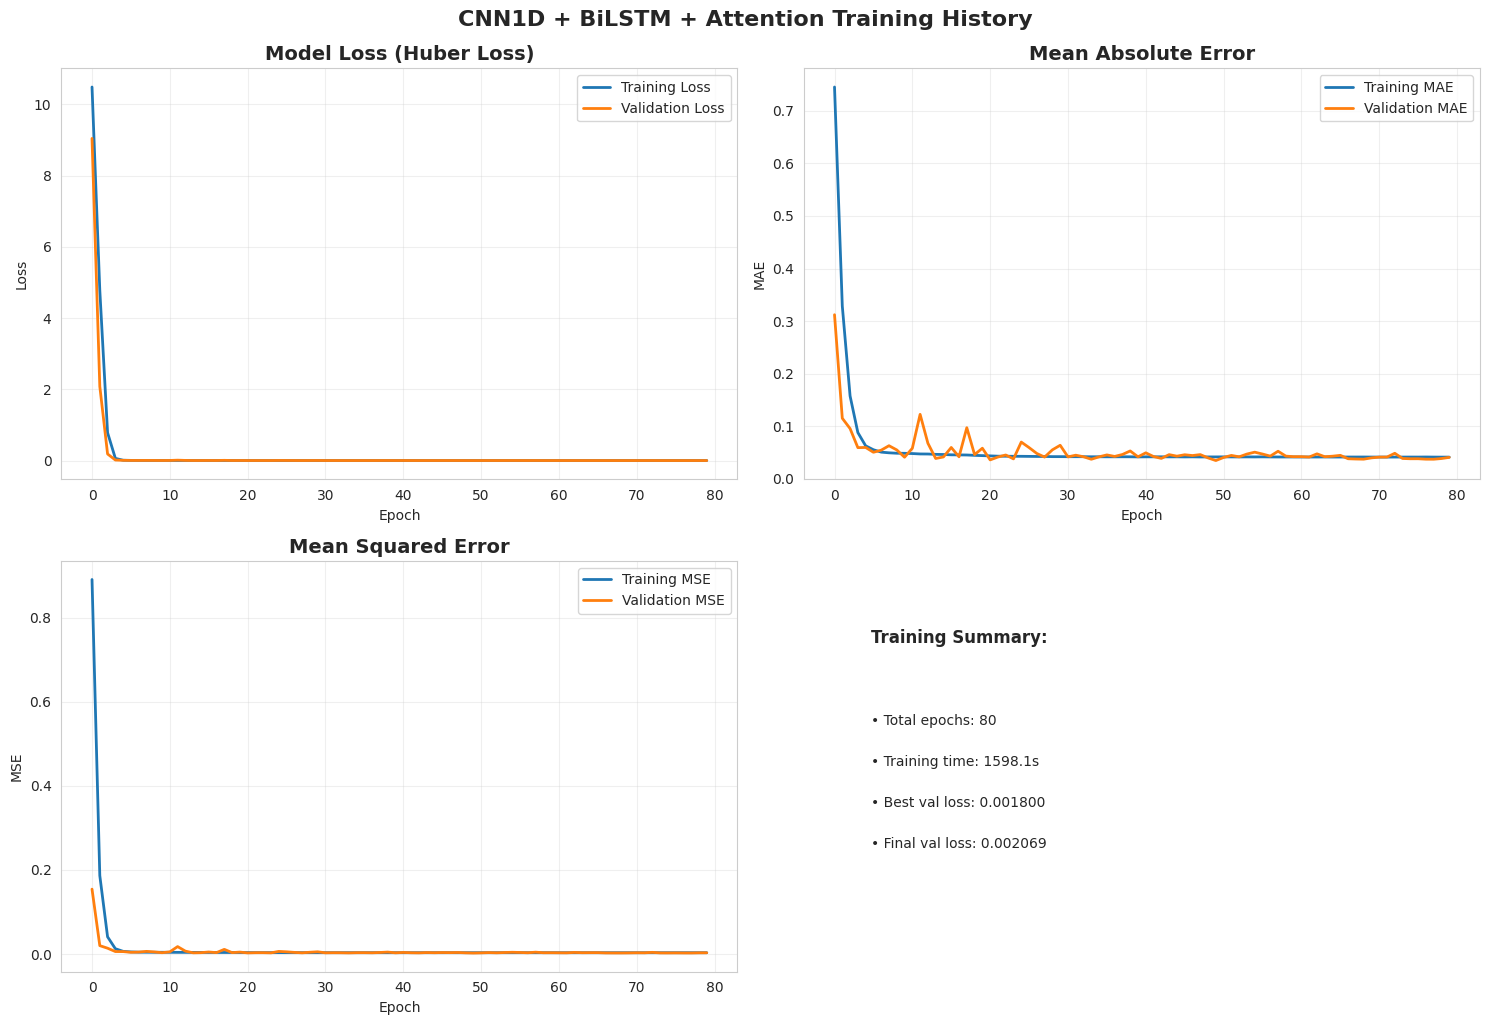


[SUMMARY] Training Summary:
   Total epochs run: 80
   Best epoch: 69
   Training time: 1598.1 seconds (26.64 minutes)
   Average time per epoch: 20.0 seconds


In [30]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss (Huber)
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss (Huber Loss)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MSE
axes[1, 0].plot(history.history['mse'], label='Training MSE', linewidth=2)
axes[1, 0].plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
axes[1, 0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    # Training summary as text
    axes[1, 1].text(0.1, 0.8, f"Training Summary:", fontsize=12, fontweight='bold')
    axes[1, 1].text(0.1, 0.6, f"• Total epochs: {len(history.history['loss'])}", fontsize=10)
    axes[1, 1].text(0.1, 0.5, f"• Training time: {training_time:.1f}s", fontsize=10)
    axes[1, 1].text(0.1, 0.4, f"• Best val loss: {min(history.history['val_loss']):.6f}", fontsize=10)
    axes[1, 1].text(0.1, 0.3, f"• Final val loss: {history.history['val_loss'][-1]:.6f}", fontsize=10)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.suptitle('CNN1D + BiLSTM + Attention Training History', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print training summary
print(f"\n[SUMMARY] Training Summary:")
print(f"   Total epochs run: {len(history.history['loss'])}")
print(f"   Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"   Training time: {training_time:.1f} seconds ({training_time/60:.2f} minutes)")
print(f"   Average time per epoch: {training_time/len(history.history['loss']):.1f} seconds")

In [31]:
# Make predictions on all datasets using trained model
print("[PREDICTIONS] Making predictions on all datasets...")

# Generate predictions
y_train_pred = model.predict(X_train, verbose=0, batch_size=256)
y_val_pred = model.predict(X_val, verbose=0, batch_size=256)
y_test_pred = model.predict(X_test, verbose=0, batch_size=256)

# Flatten predictions to 1D arrays
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_test_pred = y_test_pred.flatten()

print(f"[SUCCESS] Predictions completed:")
print(f"   Train predictions: {y_train_pred.shape}")
print(f"   Val predictions: {y_val_pred.shape}")
print(f"   Test predictions: {y_test_pred.shape}")

# Calculate metrics using safe function to avoid overflow
print("\n[METRICS] Calculating performance metrics (using safe functions):")

train_metrics = calculate_metrics_safe(y_train, y_train_pred, "Training Set")
val_metrics = calculate_metrics_safe(y_val, y_val_pred, "Validation Set")
test_metrics = calculate_metrics_safe(y_test, y_test_pred, "Test Set")

# Denormalize predictions to original scale (PM2.5 μg/m³)
print("\n[DENORMALIZE] Converting predictions to original PM2.5 scale (μg/m³)...")

# Denormalize actual values and predictions
y_test_original = denormalize_pm25(y_test, scaler_params)
y_test_pred_original = denormalize_pm25(y_test_pred, scaler_params)

print(f"[SUCCESS] Denormalized to μg/m³ scale:")
print(f"   Actual PM2.5 range: [{y_test_original.min():.2f}, {y_test_original.max():.2f}] μg/m³")
print(f"   Predicted PM2.5 range: [{y_test_pred_original.min():.2f}, {y_test_pred_original.max():.2f}] μg/m³")

# Calculate metrics on original scale using safe function
original_metrics = calculate_metrics_safe(y_test_original, y_test_pred_original, "Test Set (Original Scale μg/m³)")

# Performance assessment
print(f"\n" + "="*70)
print("🏆 PERFORMANCE ASSESSMENT")
print("="*70)

if test_metrics['r2'] > 0.8:
    print("✅ EXCELLENT: R² > 0.8 - Outstanding model performance!")
elif test_metrics['r2'] > 0.7:
    print("🟢 GOOD: R² > 0.7 - Good model performance")
elif test_metrics['r2'] > 0.6:
    print("🟡 FAIR: R² > 0.6 - Acceptable performance")
else:
    print("🔴 POOR: R² ≤ 0.6 - Needs improvement")

# Overfitting check
train_test_gap = train_metrics['r2'] - test_metrics['r2']
if train_test_gap < 0.1:
    print("✅ GENERALIZATION: Minimal overfitting detected")
elif train_test_gap < 0.2:
    print("⚠️  GENERALIZATION: Moderate overfitting detected")
else:
    print("🔴 GENERALIZATION: Significant overfitting - model memorizing training data!")

# WHO guidelines comparison
who_annual = 15  # μg/m³
who_daily = 45   # μg/m³
if original_metrics['rmse'] < who_annual:
    print(f"✅ ACCURACY: RMSE ({original_metrics['rmse']:.1f}) < WHO annual guideline ({who_annual})")
else:
    print(f"⚠️  ACCURACY: RMSE ({original_metrics['rmse']:.1f}) > WHO annual guideline ({who_annual})")

print("="*70)

[PREDICTIONS] Making predictions on all datasets...
[SUCCESS] Predictions completed:
   Train predictions: (201482,)
   Val predictions: (42725,)
   Test predictions: (42934,)

[METRICS] Calculating performance metrics (using safe functions):

[METRICS] Training Set Performance:
------------------------------------------------------------
   R²:   0.860067   (Coefficient of Determination)
   RMSE: 0.048508   (Root Mean Square Error)
   MAE:  0.033846   (Mean Absolute Error)
   MAPE: 9.8212%   (Mean Absolute Percentage Error)
   MRE:  -1.8671%   (Mean Relative Error - median)
------------------------------------------------------------

[METRICS] Validation Set Performance:
------------------------------------------------------------
   R²:   0.843848   (Coefficient of Determination)
   RMSE: 0.049184   (Root Mean Square Error)
   MAE:  0.034462   (Mean Absolute Error)
   MAPE: 9.7101%   (Mean Absolute Percentage Error)
   MRE:  -1.9835%   (Mean Relative Error - median)
----------------

In [32]:
# Advanced model evaluation - check prediction range and distribution
def evaluate_model_range(model, X_test, y_test, scaler_params):
    """Evaluate if model can predict the full range of values"""
    
    print("[EVALUATION] Advanced Model Range Analysis:")
    print("=" * 70)
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred = y_pred.flatten()
    
    # Denormalize to original scale
    y_test_orig = denormalize_pm25(y_test, scaler_params) 
    y_pred_orig = denormalize_pm25(y_pred, scaler_params)
    
    # Analyze prediction ranges
    print(f"\n[RANGES] Prediction Range Analysis:")
    print(f"   Actual PM2.5: [{y_test_orig.min():.2f}, {y_test_orig.max():.2f}] μg/m³")
    print(f"   Predicted PM2.5: [{y_pred_orig.min():.2f}, {y_pred_orig.max():.2f}] μg/m³")
    
    # Calculate range coverage
    actual_range = y_test_orig.max() - y_test_orig.min()
    pred_range = y_pred_orig.max() - y_pred_orig.min() 
    range_ratio = pred_range / actual_range
    
    print(f"   Range Coverage: {range_ratio:.1%} of actual range")
    
    # Check extreme value performance
    low_threshold = np.percentile(y_test_orig, 10)
    high_threshold = np.percentile(y_test_orig, 90)
    
    low_mask = y_test_orig <= low_threshold
    high_mask = y_test_orig >= high_threshold
    
    if np.sum(low_mask) > 10:
        low_r2 = r2_score(y_test_orig[low_mask], y_pred_orig[low_mask])
        print(f"   Low Values R² (≤{low_threshold:.1f}): {low_r2:.4f}")
    
    if np.sum(high_mask) > 10:  
        high_r2 = r2_score(y_test_orig[high_mask], y_pred_orig[high_mask])
        print(f"   High Values R² (≥{high_threshold:.1f}): {high_r2:.4f}")
    
    # Performance by value ranges
    print(f"\n[PERFORMANCE] Performance by PM2.5 ranges:")
    ranges = [(0, 15), (15, 35), (35, 75), (75, float('inf'))]
    range_names = ["Low (0-15)", "Moderate (15-35)", "High (35-75)", "Very High (75+)"]
    
    for i, (low, high) in enumerate(ranges):
        mask = (y_test_orig >= low) & (y_test_orig < high)
        if np.sum(mask) > 5:
            range_r2 = r2_score(y_test_orig[mask], y_pred_orig[mask])
            range_rmse = np.sqrt(mean_squared_error(y_test_orig[mask], y_pred_orig[mask]))
            print(f"   {range_names[i]:<15}: R²={range_r2:.4f}, RMSE={range_rmse:.2f} ({np.sum(mask)} samples)")
    
    # Return improvement suggestions
    suggestions = []
    if range_ratio < 0.7:
        suggestions.append("Increase model capacity or reduce regularization")
    if range_ratio < 0.5:
        suggestions.append("Consider ensemble methods or different loss functions")
    
    print(f"\n[SUGGESTIONS] Improvement suggestions:")
    for suggestion in suggestions:
        print(f"   • {suggestion}")
    
    return {
        'range_coverage': range_ratio,
        'pred_range': [y_pred_orig.min(), y_pred_orig.max()],
        'actual_range': [y_test_orig.min(), y_test_orig.max()]
    }

# This will be called after model training and predictions

## 5. Model Evaluation & Visualization

Đánh giá chi tiết hiệu suất mô hình và tạo các biểu đồ trực quan

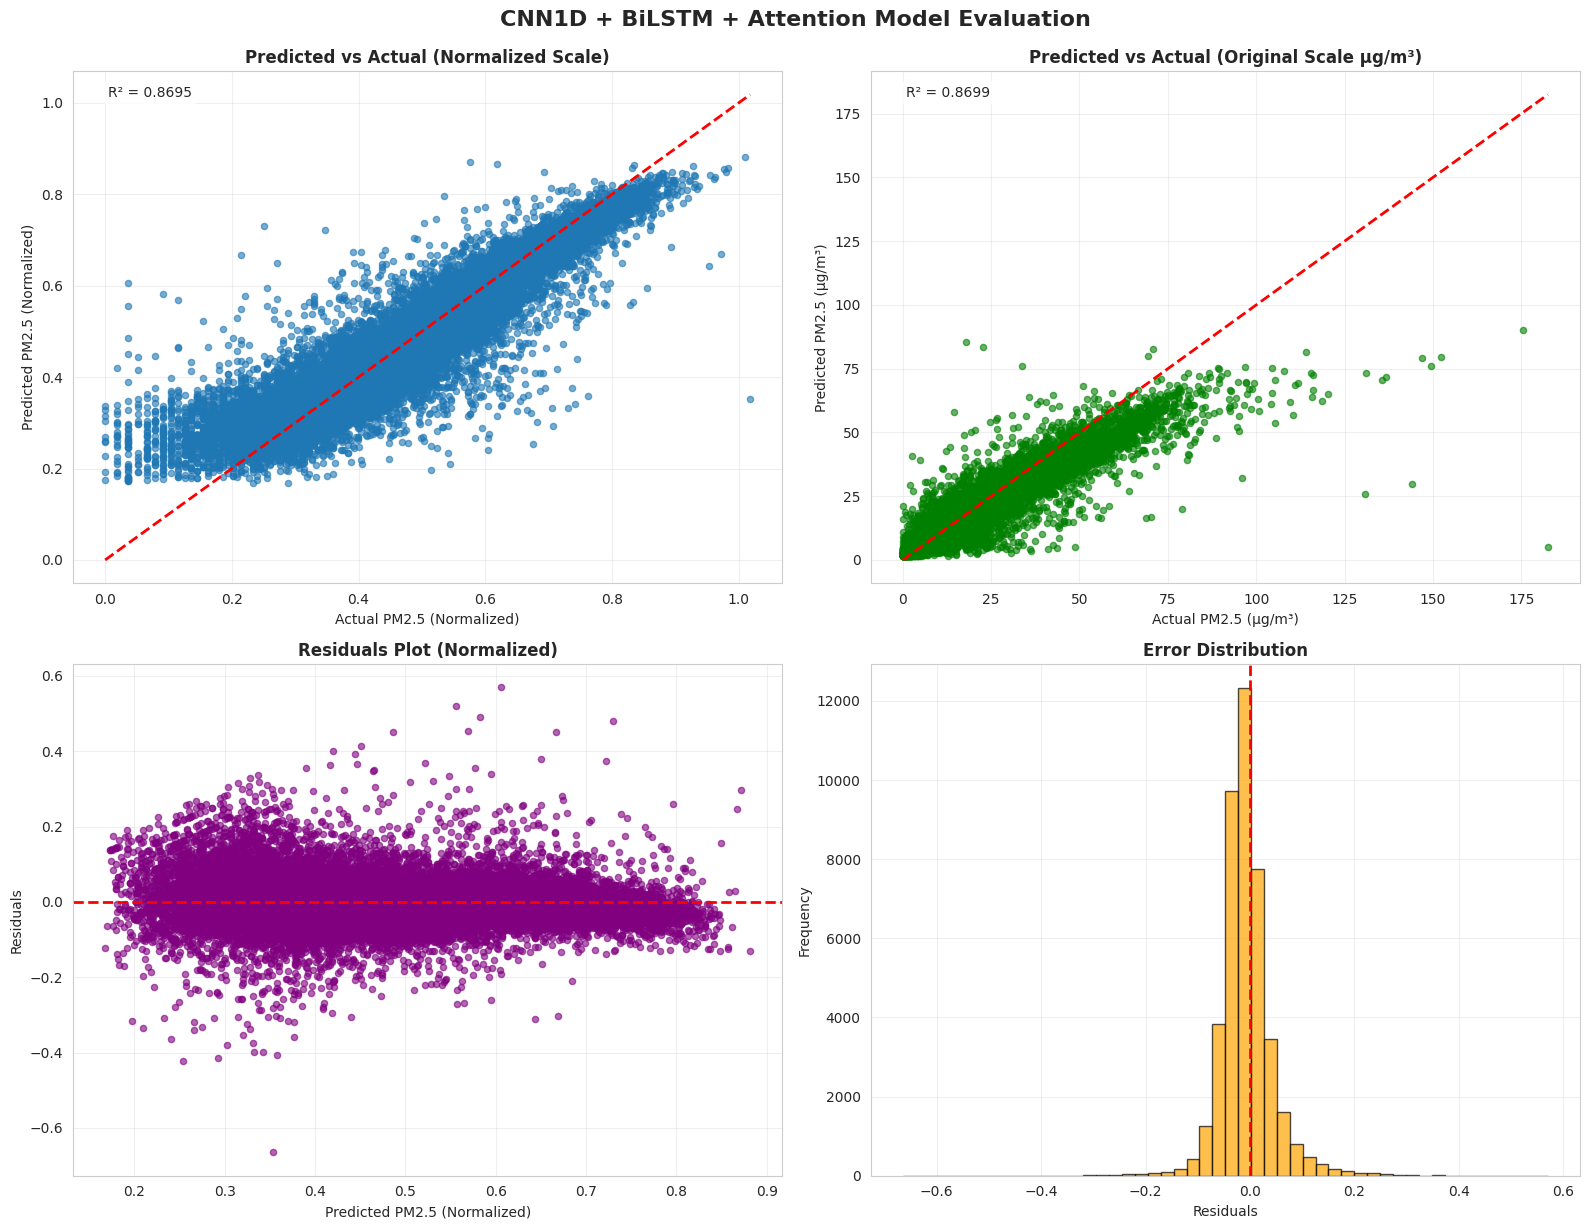


MODEL PERFORMANCE SUMMARY

[ARCHITECTURE] Model Architecture:
   • CNN1D layers: [32, 64]
   • BiLSTM units: 64
   • Self-Attention: SeqSelfAttention with ELU activation
   • Total parameters: 179,682

[TRAINING] Training Configuration:
   • Training samples: 201,482
   • Validation samples: 42,725
   • Test samples: 42,934
   • Sequence length: 24 timesteps
   • Features per timestep: 18
   • Training time: 1598.1 seconds (26.64 minutes)

[RESULTS] Final Test Performance (Original Scale) - Core Metrics:
   • R²:   0.8699     (Explanation Power)
   • RMSE: 4.68 μg/m³   (Overall Error)
   • MAE:  2.79 μg/m³   (Robust Error)
   • MAPE: 26.22%      (Percentage Error)
   • MRE:  -6.05%      (Relative Bias)


In [33]:
# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Prediction vs Actual (Normalized)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual PM2.5 (Normalized)')
axes[0, 0].set_ylabel('Predicted PM2.5 (Normalized)')
axes[0, 0].set_title('Predicted vs Actual (Normalized Scale)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
r2_norm = r2_score(y_test, y_test_pred)
axes[0, 0].text(0.05, 0.95, f'R² = {r2_norm:.4f}', transform=axes[0, 0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Prediction vs Actual (Original Scale)
axes[0, 1].scatter(y_test_original, y_test_pred_original, alpha=0.6, s=20, color='green')
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0, 1].set_title('Predicted vs Actual (Original Scale μg/m³)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
r2_orig = r2_score(y_test_original, y_test_pred_original)
axes[0, 1].text(0.05, 0.95, f'R² = {r2_orig:.4f}', transform=axes[0, 1].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Residuals Plot
residuals = y_test_pred - y_test
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.6, s=20, color='purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted PM2.5 (Normalized)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residuals Plot (Normalized)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Error Distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Error Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('CNN1D + BiLSTM + Attention Model Evaluation', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print detailed performance summary
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\n[ARCHITECTURE] Model Architecture:")
print(f"   • CNN1D layers: {MODEL_PARAMS['cnn_filters']}")
print(f"   • BiLSTM units: {MODEL_PARAMS['lstm_units']}")
print(f"   • Self-Attention: SeqSelfAttention with ELU activation")
print(f"   • Total parameters: {model.count_params():,}")

print(f"\n[TRAINING] Training Configuration:")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Validation samples: {len(X_val):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Sequence length: {X_train.shape[1]} timesteps")
print(f"   • Features per timestep: {X_train.shape[2]}")
print(f"   • Training time: {training_time:.1f} seconds ({training_time/60:.2f} minutes)")

print(f"\n[RESULTS] Final Test Performance (Original Scale) - Core Metrics:")
print(f"   • R²:   {original_metrics['r2']:.4f}     (Explanation Power)")
print(f"   • RMSE: {original_metrics['rmse']:.2f} μg/m³   (Overall Error)")
print(f"   • MAE:  {original_metrics['mae']:.2f} μg/m³   (Robust Error)")
if original_metrics['mape'] is not None:
    print(f"   • MAPE: {original_metrics['mape']:.2f}%      (Percentage Error)")
print(f"   • MRE:  {original_metrics['mre']:.2f}%      (Relative Bias)")

print("="*80)

## 6. Time Series Analysis

Phân tích dự đoán theo chuỗi thời gian để đánh giá khả năng theo dõi xu hướng

[VISUALIZE] Creating time series prediction plots...
   Test period: 2022-11-28T13:00:00.000000000 to 2025-09-30T16:00:00.000000000
   Locations: 14 locations
   Available locations: ['7727' '7737' '233335' '7735' '7732' '7740' '7742' '7730' '7734' '7733'
 '7736' '233336' '7728' '7739']


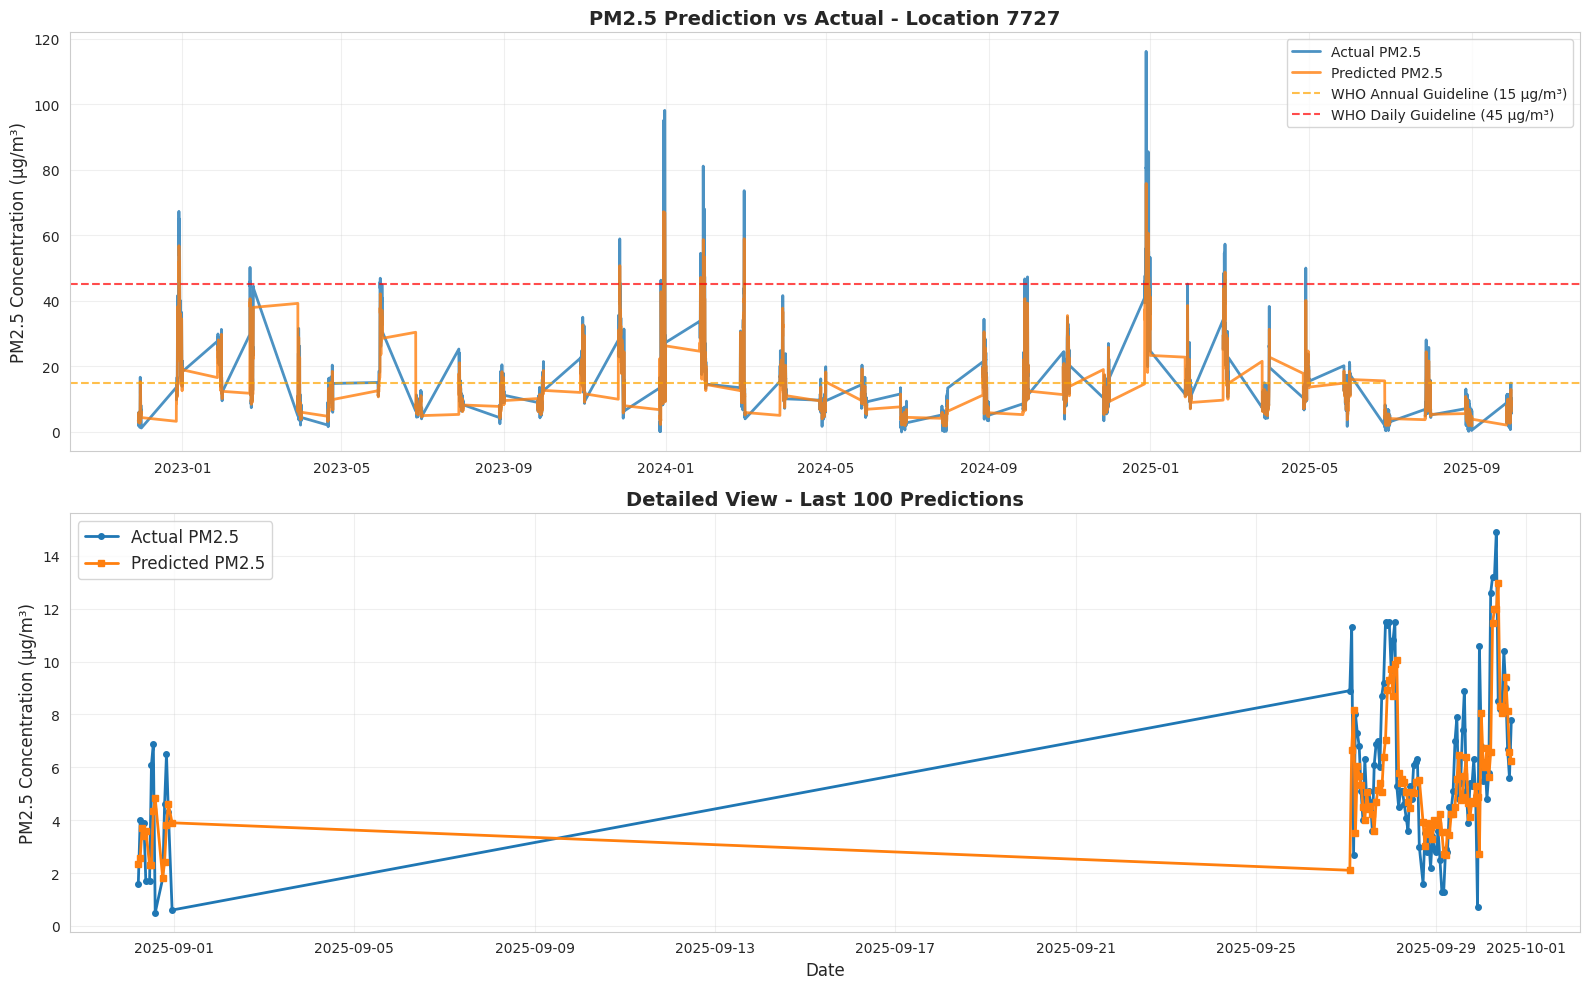


[LOCATION] Performance for Location 7727:
   • Samples: 3136
   • RMSE: 4.93 μg/m³
   • MAE:  2.98 μg/m³
   • R²:   0.8704


In [34]:
# Time series visualization using test data
print("[VISUALIZE] Creating time series prediction plots...")

# Get datetime information from test set
test_dates = cnn_test['datetime'].values
test_locations = cnn_test['location_id'].unique()

print(f"   Test period: {test_dates.min()} to {test_dates.max()}")
print(f"   Locations: {len(test_locations)} locations")
print(f"   Available locations: {test_locations}")

# Select a representative location for detailed visualization
sample_location = test_locations[0]  # Use first location
location_mask = cnn_test['location_id'] == sample_location
location_indices = np.where(location_mask)[0]

if len(location_indices) > 0:
    # Extract data for selected location
    location_dates = cnn_test.loc[location_mask, 'datetime'].values
    location_actual = y_test_original[location_indices]
    location_pred = y_test_pred_original[location_indices]
    
    # Create detailed time series plot
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Full time series
    axes[0].plot(location_dates, location_actual, label='Actual PM2.5', linewidth=2, alpha=0.8)
    axes[0].plot(location_dates, location_pred, label='Predicted PM2.5', linewidth=2, alpha=0.8)
    axes[0].set_ylabel('PM2.5 Concentration (μg/m³)', fontsize=12)
    axes[0].set_title(f'PM2.5 Prediction vs Actual - Location {sample_location}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Add WHO air quality guidelines
    axes[0].axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='WHO Annual Guideline (15 μg/m³)')
    axes[0].axhline(y=45, color='red', linestyle='--', alpha=0.7, label='WHO Daily Guideline (45 μg/m³)')
    axes[0].legend(fontsize=10)
    
    # Plot 2: Zoomed view (last 100 points for clarity)
    zoom_points = min(100, len(location_dates))
    zoom_dates = location_dates[-zoom_points:]
    zoom_actual = location_actual[-zoom_points:]
    zoom_pred = location_pred[-zoom_points:]
    
    axes[1].plot(zoom_dates, zoom_actual, 'o-', label='Actual PM2.5', linewidth=2, markersize=4)
    axes[1].plot(zoom_dates, zoom_pred, 's-', label='Predicted PM2.5', linewidth=2, markersize=4)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('PM2.5 Concentration (μg/m³)', fontsize=12)
    axes[1].set_title(f'Detailed View - Last {zoom_points} Predictions', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics for this specific location
    location_mse = mean_squared_error(location_actual, location_pred)
    location_mae = mean_absolute_error(location_actual, location_pred)
    location_r2 = r2_score(location_actual, location_pred)
    
    print(f"\n[LOCATION] Performance for Location {sample_location}:")
    print(f"   • Samples: {len(location_actual)}")
    print(f"   • RMSE: {np.sqrt(location_mse):.2f} μg/m³")
    print(f"   • MAE:  {location_mae:.2f} μg/m³")
    print(f"   • R²:   {location_r2:.4f}")
    
else:
    print("[WARNING] No data found for selected location")

[COMPARE] Multi-location performance comparison...


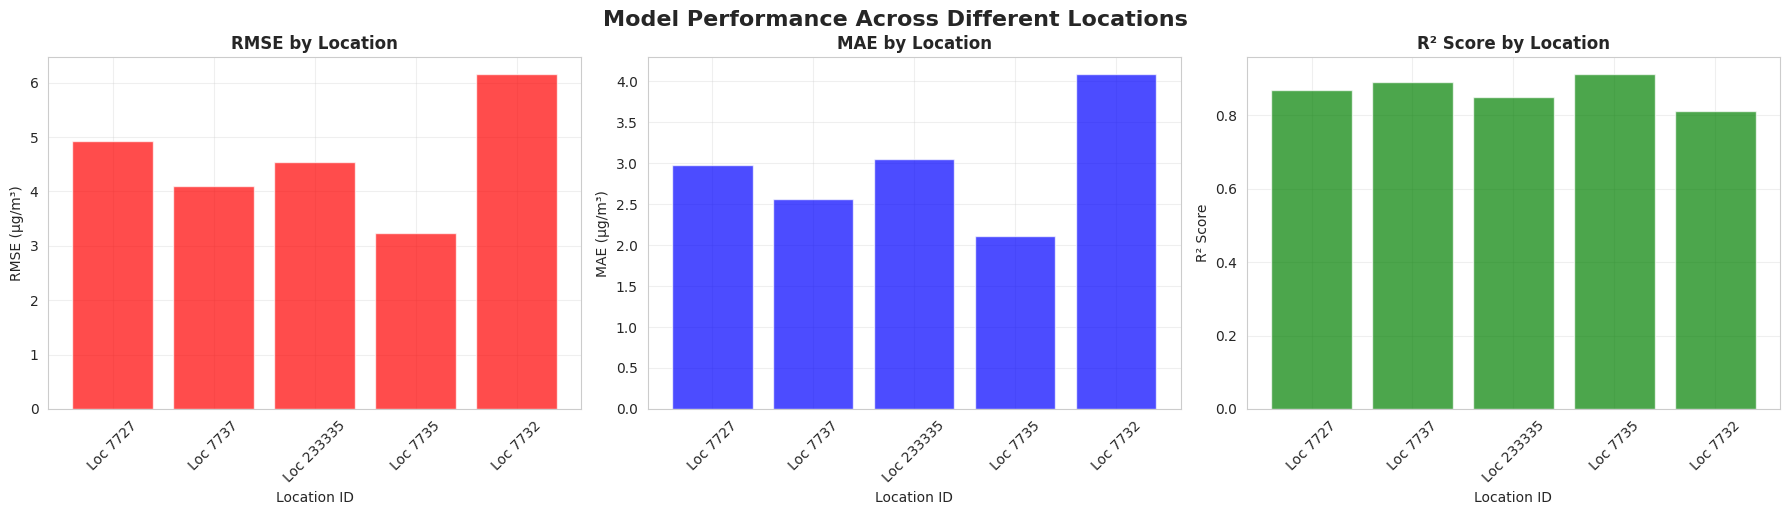


[PERFORMANCE] Location-specific performance:
----------------------------------------------------------------------
Location   Samples  RMSE       MAE        R²      
----------------------------------------------------------------------
7727       3136     4.93       2.98       0.8704  
7737       3085     4.10       2.57       0.8897  
233335     2905     4.54       3.05       0.8505  
7735       3118     3.24       2.11       0.9124  
7732       3109     6.16       4.09       0.8105  
----------------------------------------------------------------------
Average             4.60       2.96       0.8667  
Std Dev             0.96       0.66       0.0348  


In [35]:
# Multi-location comparison
print("[COMPARE] Multi-location performance comparison...")

# Calculate metrics for each location
location_performance = {}

for loc in test_locations[:5]:  # Limit to first 5 locations for clarity
    loc_mask = cnn_test['location_id'] == loc
    loc_indices = np.where(loc_mask)[0]
    
    if len(loc_indices) > 10:  # Only include locations with sufficient data
        loc_actual = y_test_original[loc_indices]
        loc_pred = y_test_pred_original[loc_indices]
        
        location_performance[loc] = {
            'samples': len(loc_actual),
            'rmse': np.sqrt(mean_squared_error(loc_actual, loc_pred)),
            'mae': mean_absolute_error(loc_actual, loc_pred),
            'r2': r2_score(loc_actual, loc_pred)
        }

# Create performance comparison plot
if location_performance:
    locations = list(location_performance.keys())
    rmse_values = [location_performance[loc]['rmse'] for loc in locations]
    mae_values = [location_performance[loc]['mae'] for loc in locations]
    r2_values = [location_performance[loc]['r2'] for loc in locations]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # RMSE comparison
    axes[0].bar(range(len(locations)), rmse_values, alpha=0.7, color='red')
    axes[0].set_xlabel('Location ID')
    axes[0].set_ylabel('RMSE (μg/m³)')
    axes[0].set_title('RMSE by Location', fontweight='bold')
    axes[0].set_xticks(range(len(locations)))
    axes[0].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # MAE comparison
    axes[1].bar(range(len(locations)), mae_values, alpha=0.7, color='blue')
    axes[1].set_xlabel('Location ID')
    axes[1].set_ylabel('MAE (μg/m³)')
    axes[1].set_title('MAE by Location', fontweight='bold')
    axes[1].set_xticks(range(len(locations)))
    axes[1].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # R² comparison
    axes[2].bar(range(len(locations)), r2_values, alpha=0.7, color='green')
    axes[2].set_xlabel('Location ID')
    axes[2].set_ylabel('R² Score')
    axes[2].set_title('R² Score by Location', fontweight='bold')
    axes[2].set_xticks(range(len(locations)))
    axes[2].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Model Performance Across Different Locations', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print location-specific performance
    print(f"\n[PERFORMANCE] Location-specific performance:")
    print("-" * 70)
    print(f"{'Location':<10} {'Samples':<8} {'RMSE':<10} {'MAE':<10} {'R²':<8}")
    print("-" * 70)
    
    for loc in locations:
        perf = location_performance[loc]
        print(f"{loc:<10} {perf['samples']:<8} {perf['rmse']:<10.2f} {perf['mae']:<10.2f} {perf['r2']:<8.4f}")
    
    # Overall statistics
    overall_rmse = np.mean(rmse_values)
    overall_mae = np.mean(mae_values)
    overall_r2 = np.mean(r2_values)
    
    print("-" * 70)
    print(f"{'Average':<10} {'':<8} {overall_rmse:<10.2f} {overall_mae:<10.2f} {overall_r2:<8.4f}")
    print(f"{'Std Dev':<10} {'':<8} {np.std(rmse_values):<10.2f} {np.std(mae_values):<10.2f} {np.std(r2_values):<8.4f}")

## 7. Model Saving & Results Summary

Lưu mô hình và tạo báo cáo tổng kết kết quả

In [36]:
# Save model and results
print("[SAVE] Saving model and results...")

# Save trained model
model_save_path = "cnn_bilstm_attention_pm25_model.keras"
model.save(model_save_path)
print(f"[SUCCESS] Model saved to: {model_save_path}")

# Prepare results summary
results_summary = {
    "model_name": "CNN1D_BiLSTM_Attention",
    "model_architecture": {
        "cnn_filters": MODEL_PARAMS['cnn_filters'],
        "lstm_units": MODEL_PARAMS['lstm_units'],
        "dropout_rate": MODEL_PARAMS['dropout_rate'],
        "total_parameters": int(model.count_params())
    },
    "training_config": {
        "epochs_run": len(history.history['loss']),
        "batch_size": TRAINING_CONFIG['batch_size'],
        "training_time_seconds": float(training_time),
        "best_epoch": int(np.argmin(history.history['val_loss']) + 1)
    },
    "dataset_info": {
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test),
        "sequence_length": int(X_train.shape[1]),
        "features_per_timestep": int(X_train.shape[2]),
        "locations_count": len(test_locations)
    },
    "performance_metrics": {
        "normalized_scale": {
            "train_rmse": float(np.sqrt(train_metrics['mse'])),
            "val_rmse": float(np.sqrt(val_metrics['mse'])),
            "test_rmse": float(np.sqrt(test_metrics['mse'])),
            "test_r2": float(test_metrics['r2'])
        },
        "original_scale_ugm3": {
            "test_rmse": float(original_metrics['rmse']),
            "test_mae": float(original_metrics['mae']),
            "test_mape": float(original_metrics['mape']) if original_metrics['mape'] is not None else None,
            "test_r2": float(original_metrics['r2'])
        }
    },
    "data_ranges": {
        "actual_pm25_range": [float(y_test_original.min()), float(y_test_original.max())],
        "predicted_pm25_range": [float(y_test_pred_original.min()), float(y_test_pred_original.max())]
    }
}

# Save results to JSON
results_path = "cnn_bilstm_attention_results.json"
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"[SUCCESS] Results saved to: {results_path}")

# Create final summary report
print("\n" + "="*90)
print("FINAL MODEL EVALUATION REPORT")
print("="*90)

print(f"\n[MODEL] CNN1D + BiLSTM + Self-Attention for PM2.5 Prediction")
print(f"   Architecture: {MODEL_PARAMS['cnn_filters']} → BiLSTM({MODEL_PARAMS['lstm_units']}) → Attention → Dense")
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Training Time: {training_time:.1f}s ({training_time/60:.2f} minutes)")

print(f"\n[DATASET] Dataset Characteristics:")
print(f"   • Total samples: {len(X_train) + len(X_val) + len(X_test):,}")
print(f"   • Sequence length: {X_train.shape[1]} timesteps (24h lookback)")
print(f"   • Features per timestep: {X_train.shape[2]} (PM10, NO2, SO2, weather, time)")
print(f"   • Locations: {len(test_locations)}")
print(f"   • PM2.5 range: {y_test_original.min():.1f} - {y_test_original.max():.1f} μg/m³")

print(f"\n[PERFORMANCE] Test Set Performance (μg/m³):")
print(f"   ✓ RMSE: {original_metrics['rmse']:.2f} μg/m³")
print(f"   ✓ MAE:  {original_metrics['mae']:.2f} μg/m³")
if original_metrics['mape'] is not None:
    print(f"   ✓ MAPE: {original_metrics['mape']:.2f}%")
print(f"   ✓ R²:   {original_metrics['r2']:.4f}")

print(f"\n[QUALITY] Model Quality Assessment:")
if original_metrics['r2'] > 0.8:
    print(f"   🟢 Excellent prediction accuracy (R² > 0.8)")
elif original_metrics['r2'] > 0.6:
    print(f"   🟡 Good prediction accuracy (R² > 0.6)")
else:
    print(f"   🔴 Fair prediction accuracy (R² ≤ 0.6)")
if original_metrics['mape'] is not None:
    if original_metrics['mape'] < 15:
        print(f"   🟢 Low prediction error (MAPE < 15%)")
    elif original_metrics['mape'] < 25:
        print(f"   🟡 Moderate prediction error (MAPE < 25%)")
    else:
        print(f"   🔴 High prediction error (MAPE ≥ 25%)")

print(f"\n[COMPARISON] WHO Air Quality Guidelines:")
who_annual = 15  # WHO annual guideline
who_daily = 45   # WHO daily guideline
print(f"   • WHO Annual Guideline: {who_annual} μg/m³")
print(f"   • WHO Daily Guideline: {who_daily} μg/m³")
print(f"   • Model RMSE: {original_metrics['rmse']:.2f} μg/m³ ({original_metrics['rmse']/who_annual*100:.1f}% of annual guideline)")

print(f"\n[SUCCESS] Model training and evaluation completed successfully!")
print(f"   Model saved: {model_save_path}")
print(f"   Results saved: {results_path}")

print("="*90)

[SAVE] Saving model and results...
[SUCCESS] Model saved to: cnn_bilstm_attention_pm25_model.keras
[SUCCESS] Results saved to: cnn_bilstm_attention_results.json

FINAL MODEL EVALUATION REPORT

[MODEL] CNN1D + BiLSTM + Self-Attention for PM2.5 Prediction
   Architecture: [32, 64] → BiLSTM(64) → Attention → Dense
   Total Parameters: 179,682
   Training Time: 1598.1s (26.64 minutes)

[DATASET] Dataset Characteristics:
   • Total samples: 287,141
   • Sequence length: 24 timesteps (24h lookback)
   • Features per timestep: 18 (PM10, NO2, SO2, weather, time)
   • Locations: 14
   • PM2.5 range: 0.0 - 182.5 μg/m³

[PERFORMANCE] Test Set Performance (μg/m³):
   ✓ RMSE: 4.68 μg/m³
   ✓ MAE:  2.79 μg/m³
   ✓ MAPE: 26.22%
   ✓ R²:   0.8699

[QUALITY] Model Quality Assessment:
   🟢 Excellent prediction accuracy (R² > 0.8)
   🔴 High prediction error (MAPE ≥ 25%)

[COMPARISON] WHO Air Quality Guidelines:
   • WHO Annual Guideline: 15 μg/m³
   • WHO Daily Guideline: 45 μg/m³
   • Model RMSE: 4.68 μ